# Prepare the corpus

In [1]:
#read the data
import pickle
with open("corpora/docs_by_chapter", "rb") as f:
    docs_by_chapter = pickle.load(f)
with open("corpora/text_to_all_chapters", "rb") as f:
    text_to_all_chapters = pickle.load(f)
with open("corpora/text_dict_joined", "rb") as f:
    text_dict_joined = pickle.load(f)
with open("corpora/corpus_chapters", "rb") as f:
    corpus_chapters = pickle.load(f)
#with open("corpora/docs_by_year", "wb") as f:
#    pickle.dump(docs_by_year, f)
#with open("corpora/docs_by_liber", "wb") as f:
#    pickle.dump(docs_by_liber, f)

In [2]:
def search_text_chapter(ind,what):
    liber, chapter = [(k, text_to_all_chapters[ind][k]) for k in text_to_all_chapters[ind]][0]
    if what == 'liber':
        return liber
    elif what == 'chapter':
        return chapter
    else:
        return text_dict_joined[liber][chapter][what]

In [ ]:
# prepare corpus files for nltk
import os
nltk_path="src/nltk/"
if not os.path.isdir(nltk_path):
    os.mkdir(nltk_path)

files_by_chapter = []
for i, doc in enumerate(docs_by_chapter):    
    #print(i, doc)
    sents = []
    sent = []
    
    for j,tok in enumerate(doc):
        sent.append(str(tok[3])+'/'+ str(tok[4]) ) #pos tags
        if tok[3] == '.' and len(sent) > 0 or j == len(doc)-1:
            sents.append(sent)
            sent = []
            #print(sent)
    if len(sents) > 0 :
        files_by_chapter.append(sents)

In [ ]:
for doc_n, doc in enumerate(files_by_chapter):
    file = os.path.join(nltk_path,str(doc_n)+ ".txt")
    doc_list = [' '.join(l)+"\n" for l in doc]
    with open(file,'w+') as f:
        f.writelines(doc_list)

In [ ]:
chapters_nltk_cats= {}
for i in range(0,len(files_by_chapter)):
    chapters_nltk_cats[str(i)+".txt"] = {"chapter":i, 
                                        "year":search_text_chapter(i,"year"),
                                        "liber":search_text_chapter(i,"liber")
                                   }

In [ ]:
from nltk.corpus.reader import CategorizedTaggedCorpusReader,TaggedCorpusReader
chapters_nltk = TaggedCorpusReader(root=nltk_path,fileids=r'^\d+.txt')
chapters_nltk_categorized = CategorizedTaggedCorpusReader(cat_map=chapters_nltk_cats,root=nltk_path,fileids=r'^\d+.txt')

In [ ]:
import re
from nltk.probability import ConditionalFreqDist
word_len_cfd = ConditionalFreqDist()
chapter_len_cfd = ConditionalFreqDist()
year_len_cfd = ConditionalFreqDist()
liber_len_cfd = ConditionalFreqDist()
chapters_nltk_categorized.fileids()
chapters_word_length = {"by_year" : {}, "by_chapter" : {}, "by_liber" : {}}
for file in chapters_nltk_categorized.fileids():
    file_id = re.sub(r'\.txt', '', file)
    #print(file_id)
    #print(search_text_chapter(int(file_id), "year"))
    year = search_text_chapter(int(file_id), "year")
    chapter = search_text_chapter(int(file_id), "chapter")
    liber = search_text_chapter(int(file_id), "liber")
    #word_lens = []
    for w in chapters_nltk_categorized.words(file):
        if w not in [';', ',', '.', '-', '"', '?', '!']:
            word_len_cfd[len(w)][w] +=1
            chapter_len_cfd[chapter][len(w)] +=1
            year_len_cfd[year][len(w)] +=1
            liber_len_cfd[liber][len(w)] +=1

In [ ]:
import plotly.express as px
import pandas as pd
pd.DataFrame(liber_len_cfd[12]).head()

In [ ]:
#length by liber
length_by_liber_list = [ (item[0], length[0], length[1]) for item in liber_len_cfd.items() for length in item[1].items() ]
length_by_year_list = [ (item[0], length[0], length[1]) for item in year_len_cfd.items() for length in item[1].items() ]
length_by_chapter_list = [ (item[0], length[0], length[1]) for item in chapter_len_cfd.items() for length in item[1].items() ]

In [ ]:
length_by_liber = pd.DataFrame.from_records(length_by_liber_list,columns=["liber", "length", "n"]).sort_values(["liber", "length"]).reset_index(drop=True)
length_by_liber["liber"] = length_by_liber["liber"].astype("category")
length_by_year = pd.DataFrame.from_records(length_by_year_list,columns=["year", "length", "n"]).sort_values(["year", "length"]).reset_index(drop=True)
length_by_year["year"] = length_by_year["year"].astype("category")
length_by_chapter = pd.DataFrame.from_records(length_by_chapter_list,columns=["chapter", "length", "n"]).sort_values(["chapter", "length"]).reset_index(drop=True)
length_by_chapter["chapter"] = length_by_chapter["chapter"].astype("category")

### Length by liber

In [ ]:
#by liber
fig = px.bar(length_by_liber,x="length", y="n", barmode="stack", color="liber")
fig.update_layout(height=800)
fig.show()

In [ ]:
#by liber
fig = px.bar(length_by_liber,x="length", y="n", barmode="stack",
             color="liber", facet_col="liber", facet_col_wrap=3)
#fig.update_yaxes(showgrid=False)
fig.update_layout(height=400,width=600, template="simple_white")
fig.update_yaxes(matches=None, ticks='',nticks=2)
fig.show(showlegend=False)

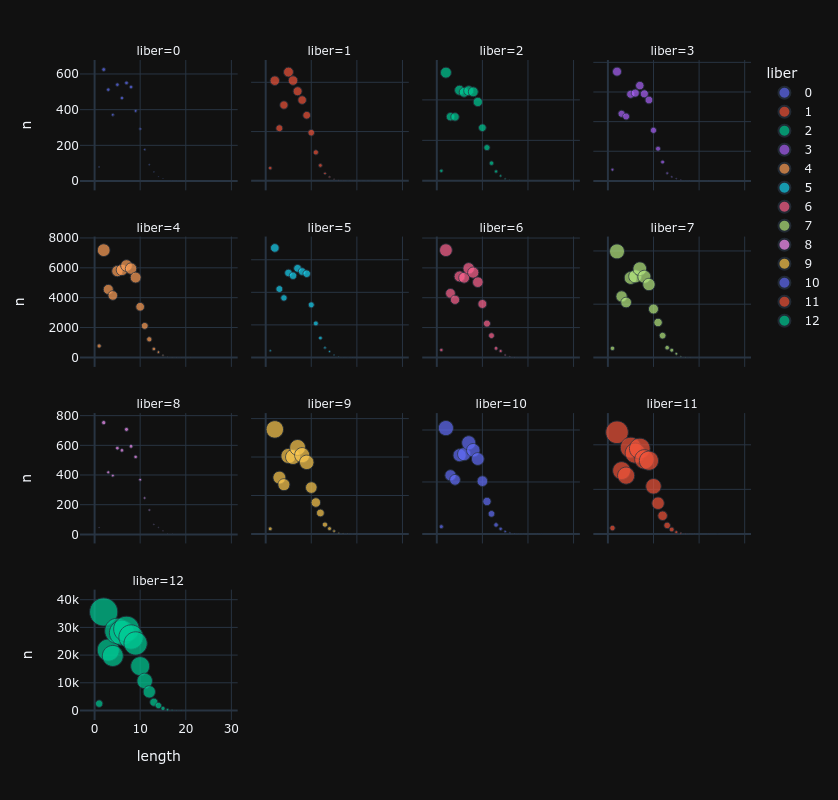

In [197]:
#by liber
fig = px.scatter(length_by_liber,x="length", y="n", size="n", color="liber", facet_col="liber", facet_col_wrap=4)
fig.update_layout(height=800,template="plotly_dark")
fig.update_yaxes(matches=None)
fig.show(show_legend=False)

### Length by year

In [310]:
length_by_year_mean = length_by_year.groupby(["year"]).apply(lambda x: sum(x["n"]*x["length"])/x["n"].sum() ).reset_index().rename({0:"mean"},axis="columns")
#length_by_year_mean.columns = ["year", "mean"]
#length_by_year_mean.rename(columns={1:"mean"})
#length_by_year_mean["year"] = length_by_year_mean["year"].astype('int8')

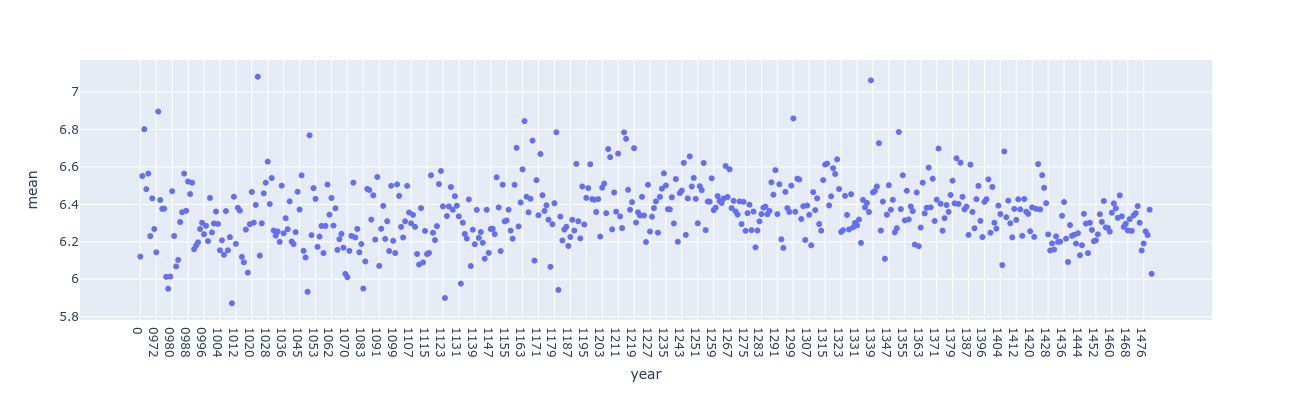

In [314]:
#by year
#fig = px.scatter(length_by_year_mean, y="mean", x="year", hover_data=["year"], trendline="ols", trendline_color_override="red")
fig = px.scatter(length_by_year_mean, y="mean", x="year", hover_data=["year"])
fig.update_layout(height=400, width=1200)
fig.show()

In [7]:
docs_by_chapter[17]

[(1, 14, 0, 'Quamvis', 'V:IND', 'UNKNOWN'),
 (1, 14, 0, 'autem', 'ADV', 'autem'),
 (1, 14, 0, 'a', 'PREP', 'a'),
 (1, 14, 0, 'primo', 'ADJ:NUM', 'unus'),
 (1, 14, 0, 'principe', 'N:abl', 'princeps'),
 (1, 14, 0, 'et', 'CC', 'et'),
 (1, 14, 0, 'conditore', 'N:abl', 'conditor'),
 (1, 14, 0, 'Lech', 'NPR', 'UNKNOWN'),
 (1, 14, 0, 'regio', 'ADJ:abl', 'regius'),
 (1, 14, 0, 'Lechia', 'N:abl', 'UNKNOWN'),
 (1, 14, 0, 'et', 'CC', 'et'),
 (1, 14, 0, 'gentes', 'N:nom', 'gens'),
 (1, 14, 0, 'eius', 'DET', 'is'),
 (1, 14, 0, 'Lechite', 'N:voc', 'UNKNOWN'),
 (1, 14, 0, 'appellate', 'N:voc', 'appellatus'),
 (1, 14, 0, 'sunt', 'ESSE:IND', 'sum'),
 (1, 14, 0, 'quia', 'CS', 'quia'),
 (1, 14, 0, 'tamen', 'ADV', 'tamen'),
 (1, 14, 0, 'in', 'PREP', 'in'),
 (1, 14, 0, 'plerisque', 'ADJ', 'UNKNOWN'),
 (1, 14, 0, 'locis', 'N:abl', 'locum|locus'),
 (1, 14, 0, 'camporum', 'N:gen', 'campus'),
 (1, 14, 0, 'planicies', 'N:nom', 'UNKNOWN'),
 (1, 14, 0, 'ad', 'PREP', 'ad'),
 (1, 14, 0, 'serendum', 'V:GER', 'sero')

In [8]:
docs_by_chapter[98]

[(2, 41, '0984', 'Boleslaus', 'N:nom', 'UNKNOWN'),
 (2, 41, '0984', 'filius', 'N:nom', 'filius'),
 (2, 41, '0984', 'Myeczlavi', 'V:IND', 'UNKNOWN'),
 (2, 41, '0984', 'Polonie', 'N:voc', 'UNKNOWN'),
 (2, 41, '0984', 'ducis', 'N:gen', 'dux'),
 (2, 41, '0984', 'diebus', 'N:abl', 'dies'),
 (2, 41, '0984', 'luctus', 'N:nom', 'luctus'),
 (2, 41, '0984', 'materni', 'ADJ', 'maternus'),
 (2, 41, '0984', 'e', 'PREP', 'e'),
 (2, 41, '0984', 'vita', 'N:abl', 'vita'),
 (2, 41, '0984', 'excessus', 'N:gen', 'excessus'),
 (2, 41, '0984', ',', 'PUN', ','),
 (2, 41, '0984', 'qui', 'REL', 'qui'),
 (2, 41, '0984', 'usque', 'ADV', 'usque'),
 (2, 41, '0984', 'in', 'PREP', 'in'),
 (2, 41, '0984', 'annum', 'N:acc', 'annus'),
 (2, 41, '0984', 'sextum', 'ADJ:NUM', 'sex'),
 (2, 41, '0984', 'tondebatur', 'V:IND', 'tondeo'),
 (2, 41, '0984', ',', 'PUN', ','),
 (2, 41, '0984', 'expletis', 'V:IND', '-'),
 (2, 41, '0984', ',', 'PUN', ','),
 (2, 41, '0984', 'Myeczslawo', 'N:voc', 'UNKNOWN'),
 (2, 41, '0984', 'patre', 

In [4]:
docs_by_chapter
text_to_all_chapters
text_dict_joined

['boleslaus',
 'filius',
 'myeczlavi',
 'polonie',
 'ducis',
 'diebus',
 'luctus',
 'materni',
 'e',
 'vita',
 'excessus',
 'qui',
 'usque',
 'in',
 'annum',
 'sextum',
 'tondebatur',
 'expletis',
 'myeczslawo',
 'patre',
 'iubente',
 'coniugalibus',
 'sacris',
 'iniciaturus',
 'et',
 'cum',
 'pannoniis',
 'veterem',
 'innovaturus',
 'amiciciam',
 'judith',
 'virginem',
 'pulcritudine',
 'et',
 'forma',
 'insignem',
 'amplissimam',
 'insuper',
 'dotem',
 'auri',
 'et',
 'argenti',
 'secum',
 'ferentem',
 'filiam',
 'yesse',
 'hungarorum',
 'ducis',
 'ex',
 'prima',
 'uxore',
 'desponsat',
 'et',
 'nupcie',
 'aput',
 'gneznensem',
 'civitatem',
 'sub',
 'presencia',
 'prelatorum',
 'et',
 'baronum',
 'qui',
 'sub',
 'frequenti',
 'numero',
 'ex',
 'polonis',
 'et',
 'hungaris',
 'convenerant',
 'in',
 'splendido',
 'apparatu',
 'et',
 'ludorum',
 'instauracione',
 'celebrantur']

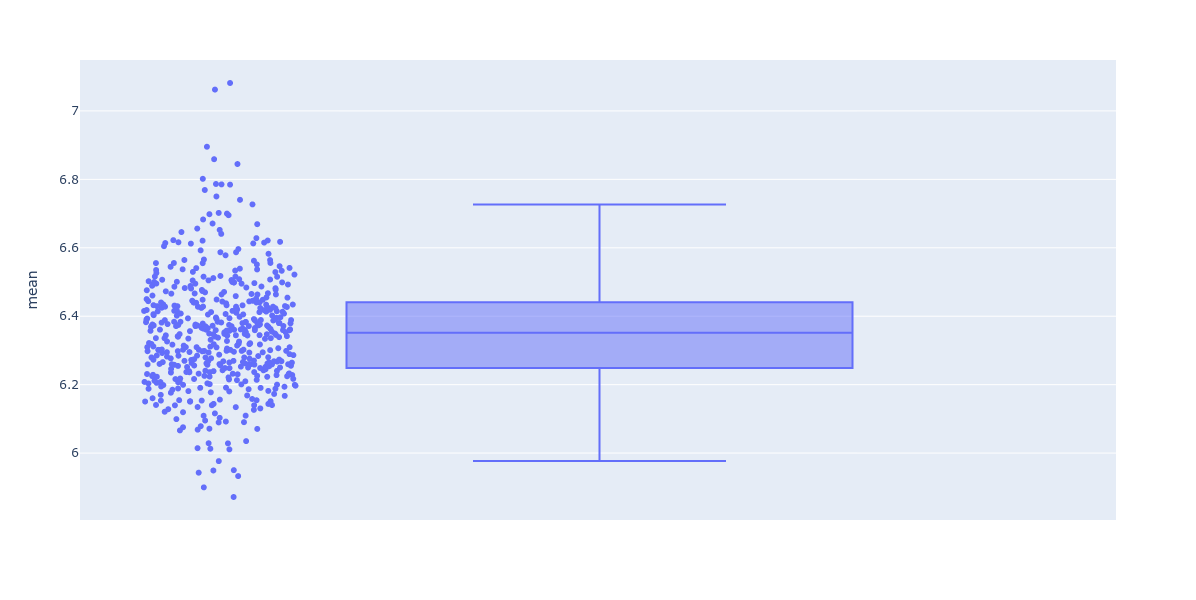

In [285]:
#by year
fig = px.box(length_by_year_mean, y="mean", points="all", hover_data=["year"])
fig.update_layout(height=600, width=400)
fig.show()

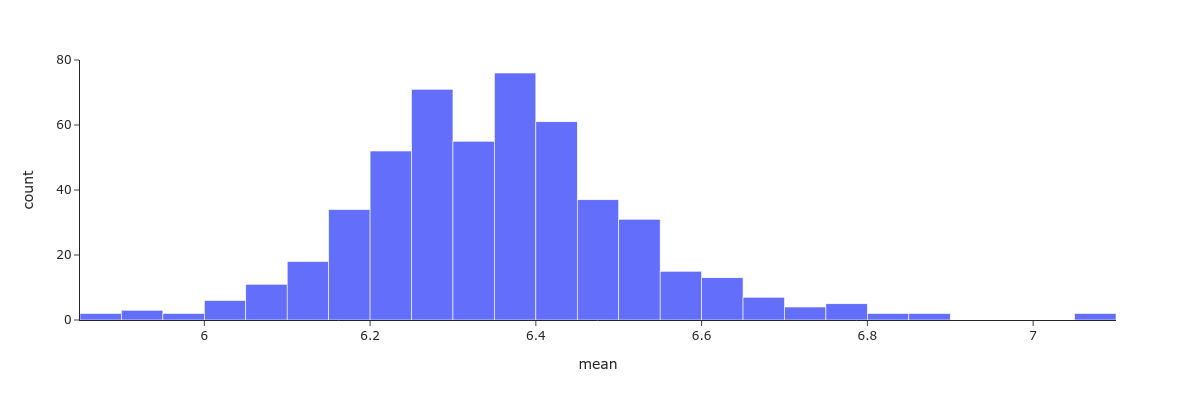

In [291]:
#by year
fig = px.histogram(length_by_year_mean, x="mean", hover_data=["year"])
#fig.update_yaxes(showgrid=False)
fig.update_layout(height=400,width=600, template="simple_white")
#fig.update_yaxes(matches=None, ticks='',nticks=2)
fig.show(showlegend=False)

### Length by chapter


In [325]:
length_by_chapter_mean = length_by_chapter.groupby(["chapter"]).apply(lambda x: sum(x["n"]*x["length"])/x["n"].sum() ).reset_index().rename({0:"mean"},axis="columns")
#length_by_year_mean.columns = ["year", "mean"]
#length_by_year_mean.rename(columns={1:"mean"})
length_by_chapter_mean["chapter"] = length_by_chapter_mean["chapter"].astype('int8')

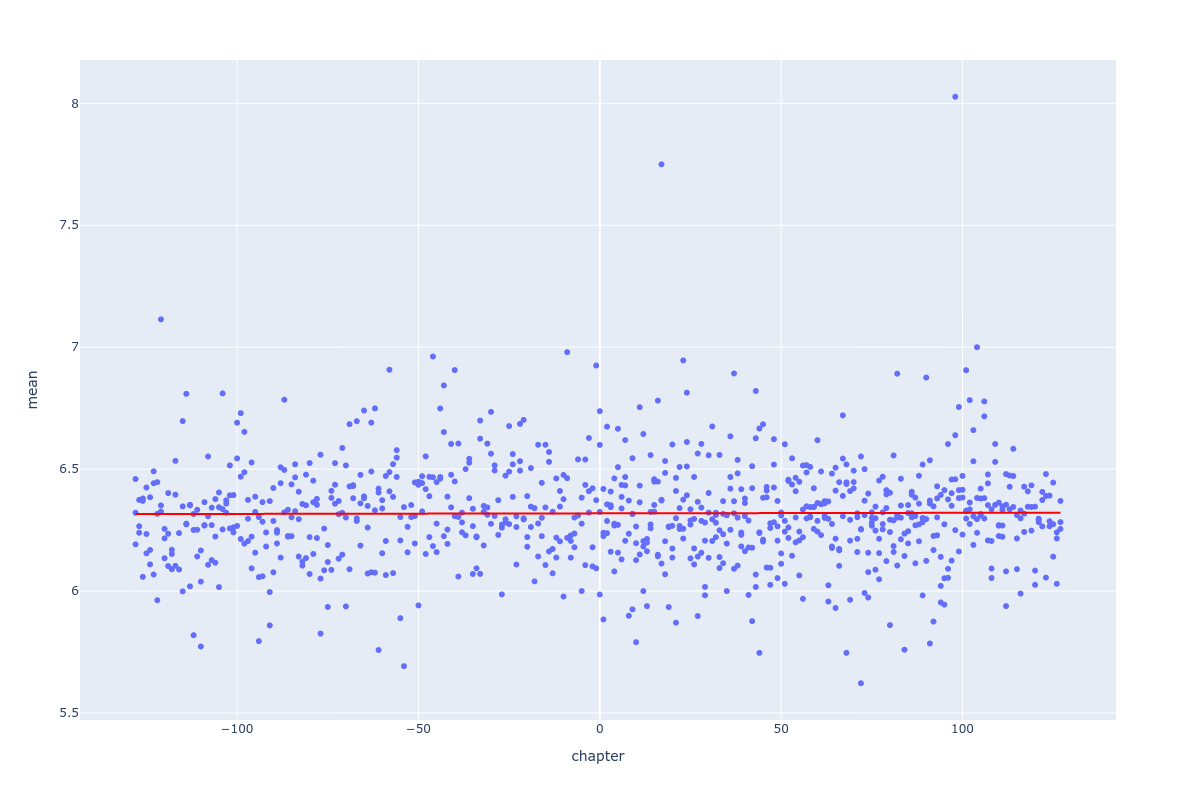

In [327]:
#by chapter
fig = px.scatter(length_by_chapter_mean,x="chapter", y="mean",trendline="ols",trendline_color_override="red")
fig.update_layout(height=800)
fig.show()

In [12]:
docs_by_chapter[584]

[(6, 57, '1190', 'Wnelphus', 'N:nom', 'UNKNOWN'),
 (6, 57, '1190', 'Wladislaviensis', 'N:gen', 'UNKNOWN'),
 (6, 57, '1190', 'episcopus', 'N:nom', 'episcopus'),
 (6, 57, '1190', 'cum', 'PREP', 'cum'),
 (6, 57, '1190', 'annis', 'N:abl', 'annus'),
 (6, 57, '1190', 'decem', 'ADJ:NUM', 'decem'),
 (6, 57, '1190', 'et', 'CC', 'et'),
 (6, 57, '1190', 'paulo', 'N:abl', 'Paulus|paulum'),
 (6, 57, '1190', 'amplius', 'ADV', 'ample|amplius|amplus'),
 (6, 57, '1190', 'Wladislaviensem', 'N:acc', 'UNKNOWN'),
 (6, 57, '1190', 'ecclesiam', 'N:acc', 'ecclesia'),
 (6, 57, '1190', 'rexisset', 'V:SUB', 'rego'),
 (6, 57, '1190', ',', 'PUN', ','),
 (6, 57, '1190', 'moritur', 'V:IND', 'morior'),
 (6, 57, '1190', 'et', 'CC', 'et'),
 (6, 57, '1190', 'in', 'PREP', 'in'),
 (6, 57, '1190', 'veteri', 'ADJ', 'veter|vetus'),
 (6, 57, '1190', 'Wladislaviensi', 'N:abl', 'UNKNOWN'),
 (6, 57, '1190', 'ecclesia', 'N:nom', 'ecclesia'),
 (6, 57, '1190', 'sepelitur', 'V:IND', 'sepelio|sepelo'),
 (6, 57, '1190', '.', 'SENT', '

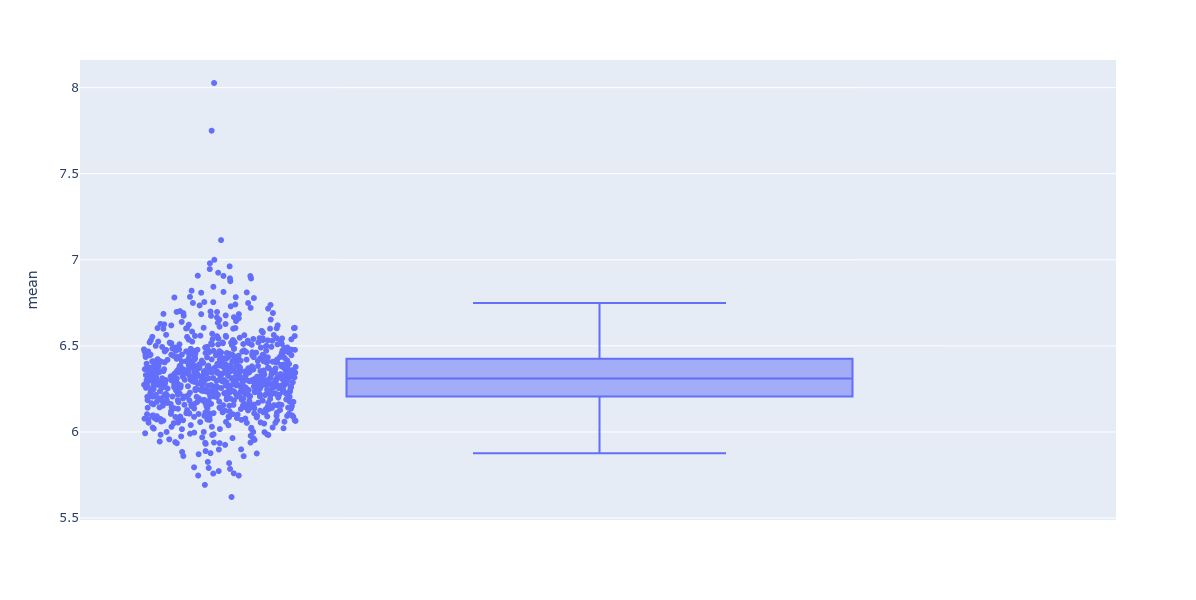

In [323]:
#by chapter
fig = px.box(length_by_chapter_mean, y="mean", points="all", hover_data=["chapter"])
fig.update_layout(height=600, width=600)
fig.show()

### Lexical Richness

In [333]:
# lexical richness
from lexicalrichness import LexicalRichness
lex_rich =  LexicalRichness([tok for chap in corpus_chapters for tok in chap ], preprocessor=None, tokenizer=None)

<Axes: xlabel='Sample size', ylabel='TTR'>

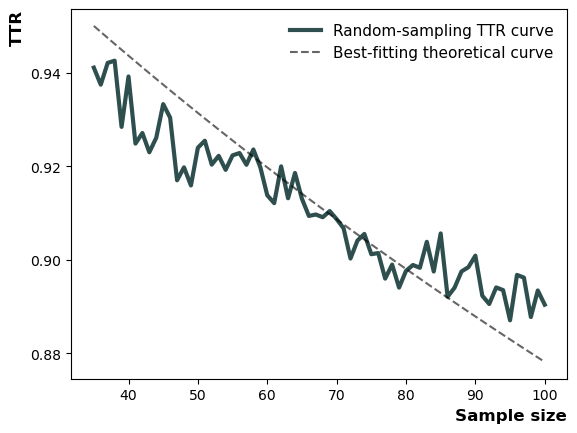

In [340]:
lex_rich.vocd_fig(ntokens=100)

In [370]:
from lexicalrichness import LexicalRichness
import numpy as np
chunk_n = 10
indices = np.array_split(np.array(range(0,len(corpus_chapters))),chunk_n)
lex_richs = []
figs = []
for chunk in indices:
    lex_richs.append(LexicalRichness([tok for chap in corpus_chapters[chunk[0]:chunk[-1]] for tok in chap ], preprocessor=None, tokenizer=None))

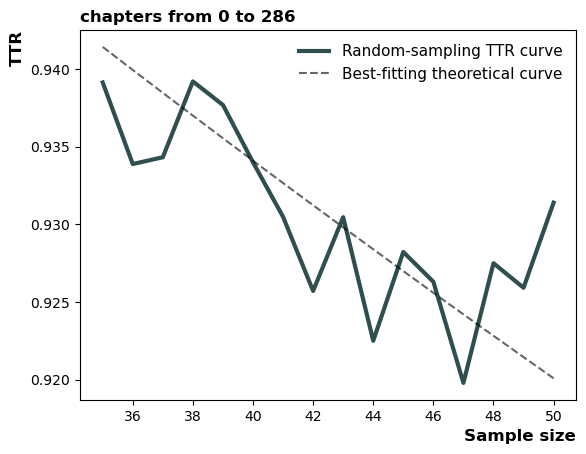

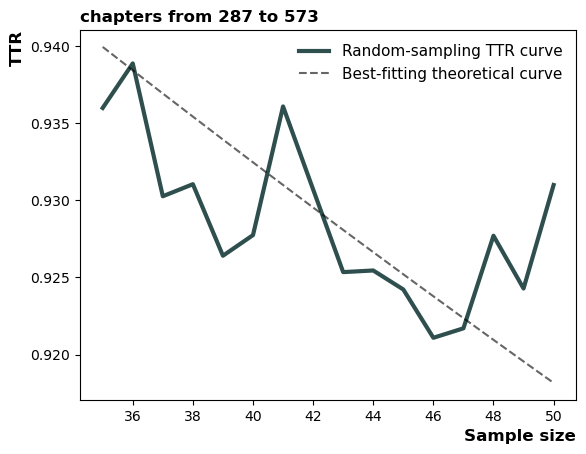

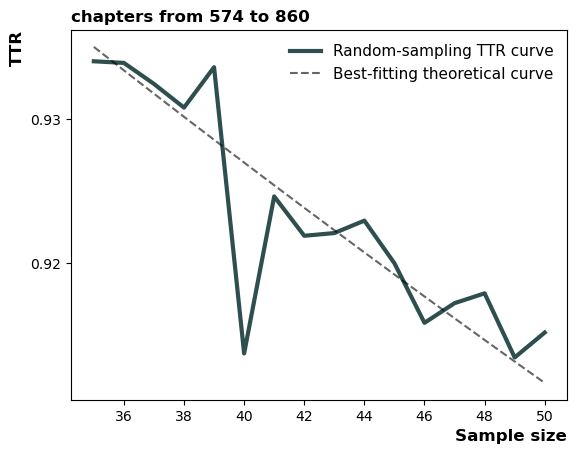

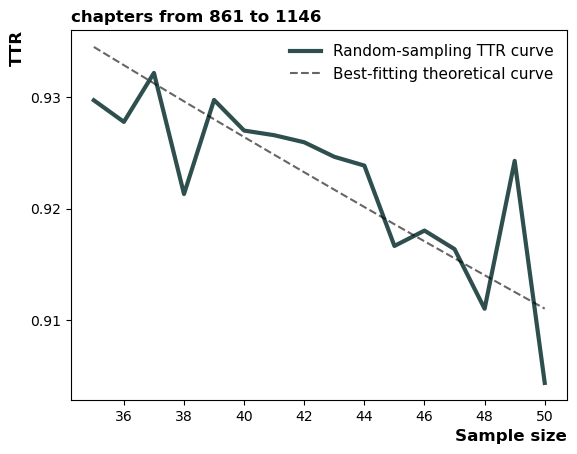

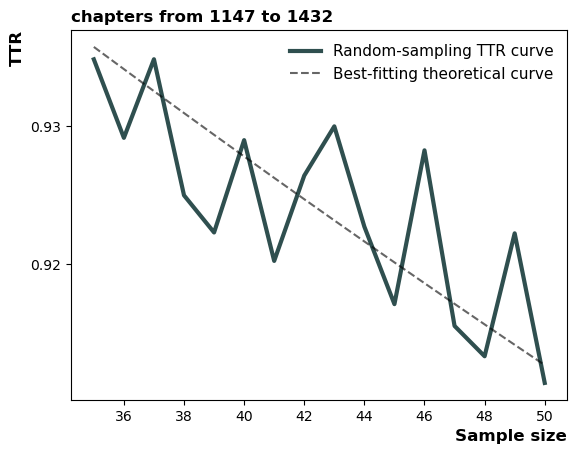

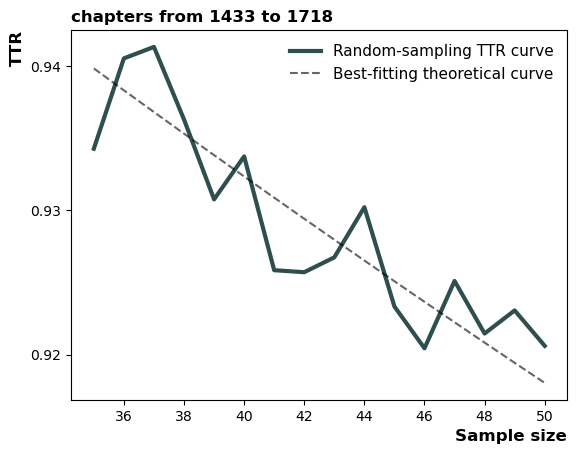

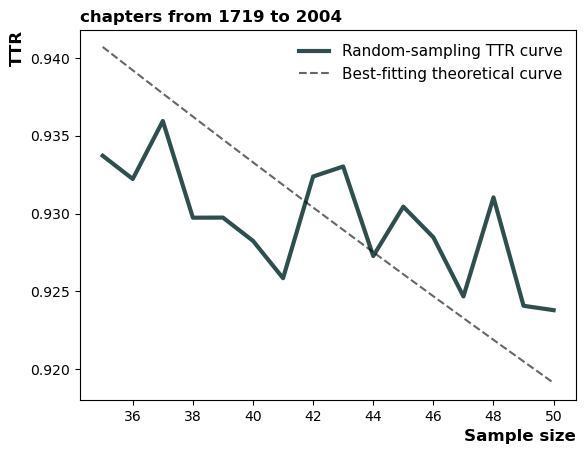

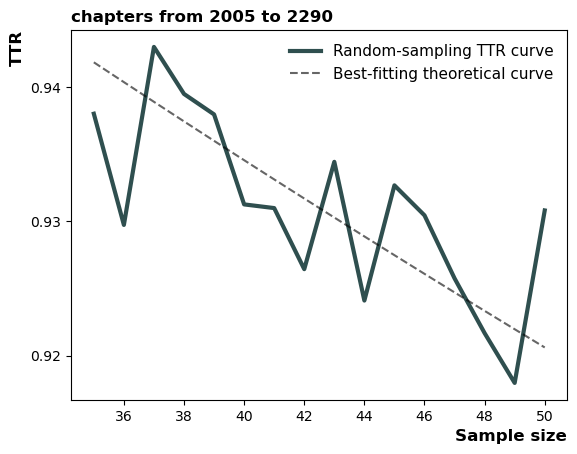

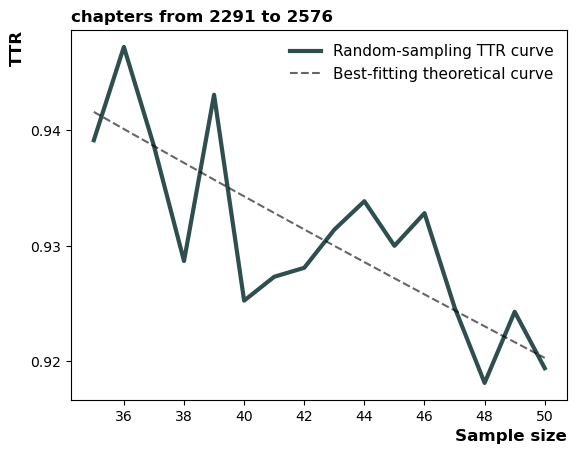

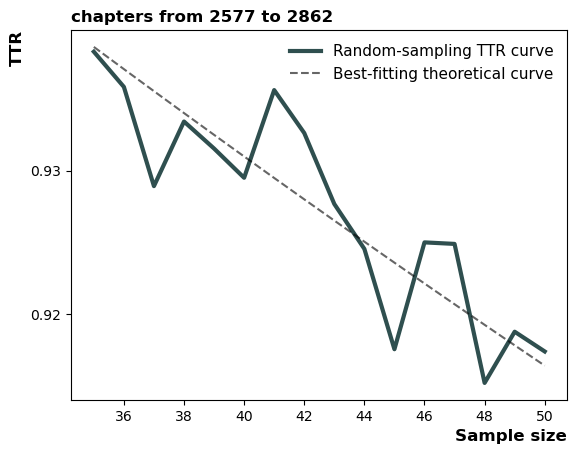

In [391]:
#import matplotlib.pyplot as plt
#fig, axs = plt.subplots(chunk_n)
for chunk,lex_rich in enumerate(lex_richs):
    lex_rich.vocd_fig(title="chapters from " + str(indices[chunk][0]) + " to " + str(indices[chunk][-1]))

### Variation

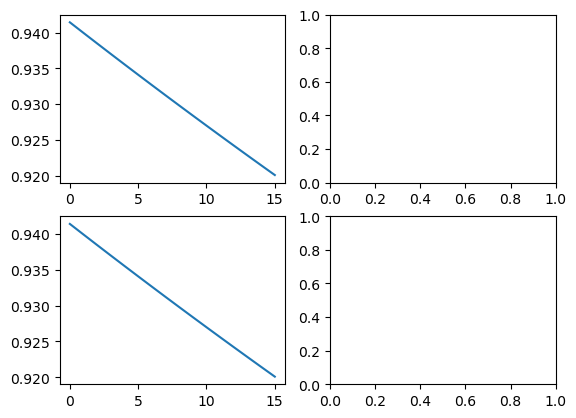

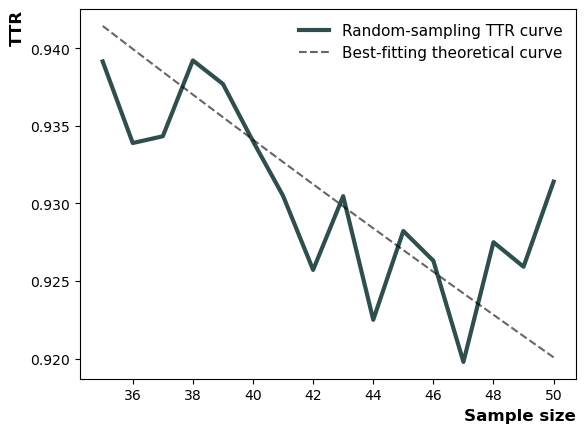

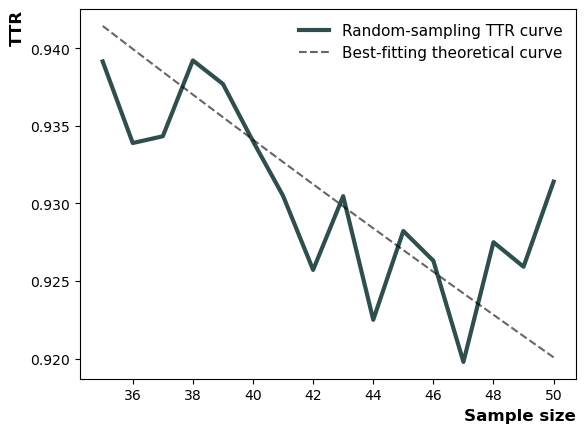

In [390]:
#import matplotlib.pyplot as plt
#fig, axs = plt.subplots(2,2)
#axs[0,0].plot(lex_richs[0].vocd_fig(return_data=True)[3])
#axs[1,0].plot(lex_richs[0].vocd_fig(return_data=True)[3])

In [364]:
corpus_chapters[(0,1,2)]

TypeError: list indices must be integers or slices, not tuple

In [457]:
docs_by_chapter_df = pd.DataFrame.from_records([tok for chapter in docs_by_chapter for tok in chapter ],columns=["liber","chapter", "year", "word", "pos", "lemma"])
docs_by_chapter_df["length"] = docs_by_chapter_df["word"].apply(lambda x:len(x))
docs_by_chapter_df[~docs_by_chapter_df["word"].isin(['.', ',', ';', '-'])].head()
docs_by_chapter_df_group = docs_by_chapter_df.groupby(["chapter","pos"]).agg({"pos":"count"}).rename(columns={"pos":"count"}).reset_index()
from sklearn.decomposition import FactorAnalysis
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(np.array(docs_by_chapter_df_group["count"]))

ValueError: Expected 2D array, got 1D array instead:
array=[212.   5.  51. ...  12.  20.  34.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [453]:
docs_by_chapter_df.head()

,liber,chapter,year,word,pos,lemma,length
0,0,0,0,REVERENDISSIMO,ADJ,UNKNOWN,14
1,0,0,0,IN,N:nom,UNKNOWN,2
2,0,0,0,CHRISTO,ADJ,UNKNOWN,7
3,0,0,0,PATRI,N:dat,pater,5
4,0,0,0,",",PUN,",",1


In [443]:
pca = PCA()

pca.fit(X_scaled)

PCA(copy=True, n_components=None, whiten=False)

len(pca.components_)

55

55 dimensions (or components, or axes) were used in the Principal Component Analysis.

print 'Explained Variance Ratio = ', sum(pca.explained_variance_ratio_[: 2])

Explained Variance Ratio =  0.483937328909

We can see that almost half (~48%) of the total variance comes from only two dimensions (i.e., the first two principal components). Let's visualize the relative contribution of all components.

data3 = pgo.Data([
    pgo.Bar(
            y=pca.explained_variance_ratio_,
    )
])

py.iplot(data3, filename="baltimore-principal-dimensions")

Let's plot a cumulative version of this, to see how many dimensions are needed to account for 90% of the total variance.

data4 = pgo.Data([
    pgo.Scatter(
            y=np.cumsum(pca.explained_variance_ratio_),
    )
])

py.iplot(data4, filename='baltimore-pca-cumulative')

So we need about 20 dimensions to explain ~90% of the total variance.

Let's focus on the 2 principal dimensions, so it's easy to plot them in the (x, y) plane.

pca.n_components = 2
X_reduced = pca.fit_transform(X_scaled)
df_X_reduced = pd.DataFrame(X_reduced, index=df.index)

trace = pgo.Scatter(x=df_X_reduced[0],
                    y=df_X_reduced[1],
                    text=df.index,
                    mode='markers',
                    # Size by total population of each neighborhood. 
                    marker=pgo.Marker(size=df['tpop10'],
                                      sizemode='diameter',
                                      sizeref=df['tpop10'].max()/50,
                                      opacity=0.5)
)

data5 = pgo.Data([trace])

layout5 = pgo.Layout(title='Baltimore Vital Signs (PCA)',
                     xaxis=pgo.XAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     yaxis=pgo.YAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     hovermode='closest'
)

fig5 = pgo.Figure(data=data5, layout=layout5)
py.iplot(fig5, filename='baltimore-2dim')

,chapter,pos,count
0,0,ADJ,212
1,0,ADJ:COM,5
2,0,ADJ:NUM,51
3,0,ADJ:SUP,4
4,0,ADJ:abl,33
...,...,...,...
29204,880,V:PTC,5
29205,880,V:PTC:abl,7
29206,880,V:PTC:acc,12
29207,880,V:PTC:nom,20
